In [31]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

Download datasets<br>
Power transitions dataset has both data for power transition years and data for 100 year timesteps. The column "dataset" is either PT or 100y to keep track.<br>
The datasets are saved separatly as well as together in dataset_FULL.

In [32]:
use_resid = False

if use_resid:
    # Load the residuals
    dataset_filename = '..\datasets\power_transitions_with_residuals.xlsx'
else:
    dataset_filename = '..\datasets\power_transitions.xlsx'

dataset_PT = TSD(file_path=dataset_filename)
dataset_PT.scv = dataset_PT.scv.groupby('dataset').get_group('PT')
dataset_PT.scv_imputed = dataset_PT.scv_imputed.groupby('dataset').get_group('PT')

dataset_FULL = TSD(file_path=dataset_filename)
dataset_100y = TSD(file_path=dataset_filename)
dataset_100y.scv = dataset_100y.scv.groupby('dataset').get_group('100y')
dataset_100y.scv_imputed = dataset_100y.scv_imputed.groupby('dataset').get_group('100y')

Dataset loaded from ..\datasets\power_transitions.xlsx
Dataset loaded from ..\datasets\power_transitions.xlsx
Dataset loaded from ..\datasets\power_transitions.xlsx


# Calculate MSP

Take MSP from Polaris dataset

In [33]:
polaris_filename = "..\datasets\Polaris_data.xlsx"
religion_df = pd.read_excel(polaris_filename, sheet_name='Religion')

for dataset in [dataset_PT, dataset_FULL, dataset_100y]:
    dataset.scv['religion'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv_imputed['religion'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv['religion_family'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv_imputed['religion_family'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv['MSP'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv_imputed['MSP'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

Add crisis variables to PT dataset.<br>
Add each crisis variable as a column in scv and scv_imputed datasets. <br>
Create Crisis variable which is a mean of the first 4 crisis types: overturn, assassination, intra-elite, popular_uprising.

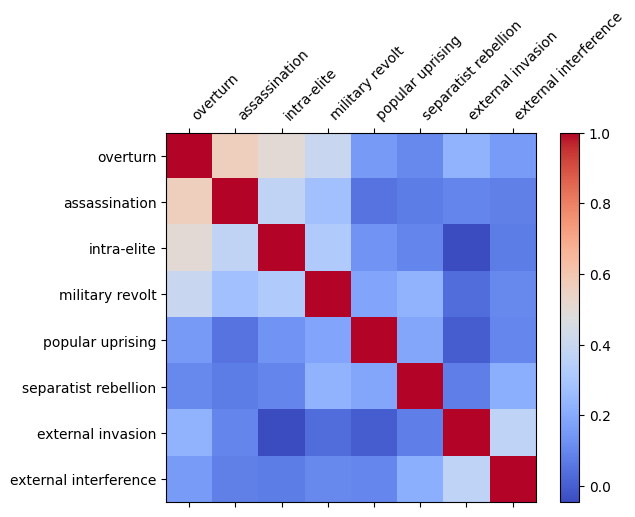

In [34]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
# columns to sum into crisis variable
crisis_keep = ['overturn', 'predecessor_assassination', 'intra_elite', 'military_revolt']
PT_mapping = {'PT_types':{}}
for c,col in enumerate(crisis_vars):
    if col in crisis_keep:
        PT_mapping['PT_types'][col] = 1
    dataset_PT.scv[col] = dataset_PT.raw[col]
    dataset_PT.scv_imputed[col] = dataset_PT.scv[col]

dataset_PT.scv['Crisis'] = dataset_PT.raw.apply(lambda row: weighted_mean(row, PT_mapping, "PT_types", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Crisis'] = dataset_PT.scv['Crisis']
dataset_PT.scv['duration'] = dataset_PT.raw['duration']
dataset_PT.scv_imputed['duration'] = dataset_PT.scv['duration']

# plot correlation matrix between crisis variables
corr = dataset_PT.scv[crisis_vars].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
labels = ['overturn','assassination','intra-elite','military revolt','popular uprising','separatist rebellion','external invasion','external interference']
ax.set_xticklabels(labels, rotation=45, ha='left')
ax.set_yticklabels(labels)
plt.colorbar(cax)
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1417044710.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_plot.sort_values('Crisis', inplace=True,ascending=True)


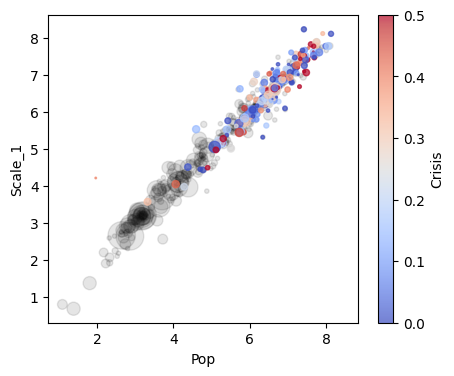

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 4))

dataset_plot_100 = dataset_100y.scv_imputed.dropna(subset = ['Scale_1', 'Pop'])
polity_group_100 = dataset_100y.scv_imputed.groupby('PolityName')

mean_comp_100 = polity_group_100['Scale_1'].mean()
mean_scale_100 = polity_group_100['Pop'].mean()
num_observations_100 = polity_group_100['Year'].max() - polity_group_100['Year'].min()

scatter = plt.scatter(mean_scale_100, mean_comp_100,
                      c='black',
                      s=num_observations_100/10,
                      alpha=0.1,
                      )

dataset_plot = dataset_PT.scv_imputed.dropna(subset = ['Scale_1', 'Pop', 'predecessor_assassination'])
dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
polity_group = dataset_PT.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Scale_1'].mean()
mean_scale_1 = polity_group['Pop'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group['Year'].max() - polity_group['Year'].min()

v_max = mean_crisis.max()*0.5
v_min = mean_crisis.min()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = v_min,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations /10,
                      alpha=0.7,
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Scale_1')
plt.xlabel('Pop')
plt.show()

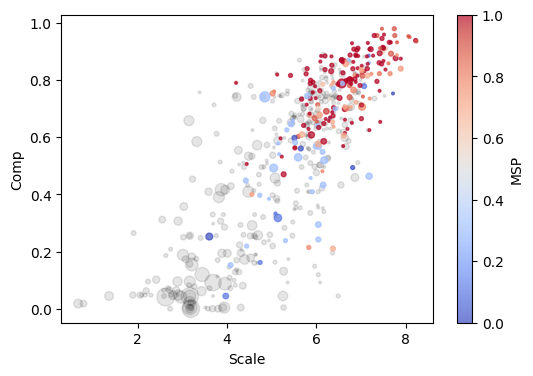

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset_100y.scv_imputed
gray_plot = gray_plot[pd.isna(gray_plot['MSP'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['Comp'].mean()
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 4,
                      alpha=0.1,
                      )


dataset_plot = dataset_100y.scv_imputed
dataset_plot = dataset_plot.dropna(subset = ['Comp', 'Scale_1', 'MSP'])
polity_group = dataset_plot.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['MSP'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 4,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='MSP')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

# Plot scale and comp

C:\Users\matil\AppData\Local\Temp\ipykernel_22884\500665668.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_plot.sort_values('Crisis', inplace=True,ascending=True)


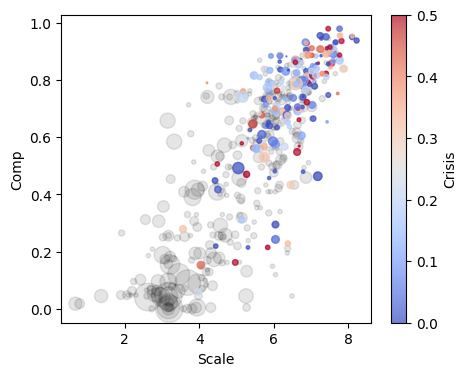

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 4))

dataset_plot_100 = dataset_100y.scv_imputed.dropna(subset = ['Comp', 'Scale_1'])
polity_group_100 = dataset_100y.scv_imputed.groupby('PolityName')

mean_comp_100 = polity_group_100['Comp'].mean()
mean_scale_100 = polity_group_100['Scale_1'].mean()
num_observations_100 = polity_group_100['Year'].max() - polity_group_100['Year'].min()

scatter = plt.scatter(mean_scale_100, mean_comp_100,
                      c='black',
                      s=num_observations_100/10,
                      alpha=0.1,
                      )

dataset_plot = dataset_PT.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
polity_group = dataset_PT.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group['Year'].max() - polity_group['Year'].min()

v_max = mean_crisis.max()*0.5
v_min = mean_crisis.min()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = v_min,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations /10,
                      alpha=0.7,
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

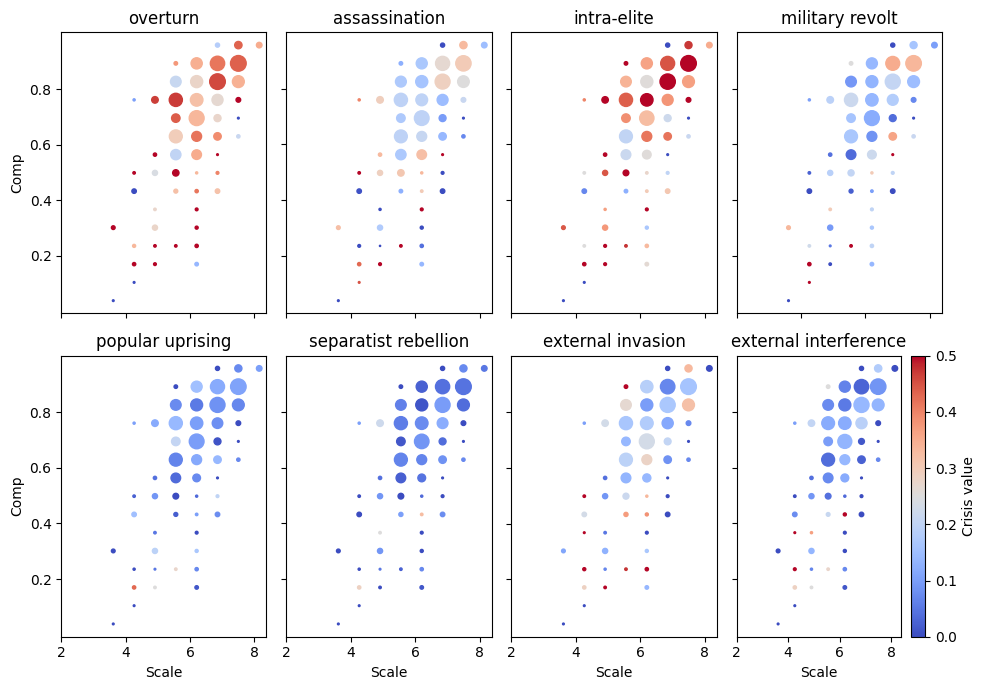

In [38]:
scv_imp = dataset_PT.scv_imputed
nbins = 15
scale = np.linspace(0, 10, nbins)
delta = scale[1] - scale[0]
comp = np.zeros(nbins)
comp_std = np.zeros(nbins)
crisis = np.zeros((len(crisis_vars), nbins))

labels = ['overturn','assassination','intra-elite','military revolt','popular uprising','separatist rebellion','external invasion','external interference']

for i in range(nbins):
    comp[i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)]['Comp'].dropna().mean()
    comp_std[i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)]['Comp'].dropna().std()
    for j, col in enumerate(crisis_vars):
        crisis[j, i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)][col].dropna().mean()

fig, axes = plt.subplots(2, 4, figsize=(10, 7))
axes = axes.flatten()
vmax = 0.5
for v in range(len(crisis_vars)):
    x_cols = ['Scale_1', 'Comp']
    y_col = crisis_vars[v]
    Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
    x = Xy[x_cols[0]].values
    y = Xy[x_cols[1]].values
    z = Xy[y_col].values

    grid_size = 15

    df = pd.DataFrame({'x': x, 'y': y, 'z': z})

    # Define the grid
    x_bins = np.linspace(0,10, grid_size + 1)
    y_bins = np.linspace(0,1, grid_size + 1)

    # Bin the data
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
    grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
    counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()
    x,y = np.meshgrid(x_bins, y_bins)

    axes[v].scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten()*0.8, vmax = 0.5)
    axes[v].grid(False)
    axes[v].set_title(labels[v])
    if v>=4:
        axes[v].set_xlabel('Scale')
    else:
        axes[v].set_xticklabels([])
    if (v == 0) or (v == 4):
        axes[v].set_ylabel('Comp')
    else:
        # remove y tick labels
        axes[v].set_yticklabels([])
    axes[v].set_yticks([0.2,0.4,0.6,0.8])
    axes[v].set_xticks([2,4,6,8])
# Add a colorbar to the last axis
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(0, vmax))
sm.set_array([])
fig.colorbar(sm, ax=axes[-1], orientation='vertical', label='Crisis value')
plt.tight_layout()
plt.show()

# Run linear regression

Testing Scale and Comp only

In [39]:
import statsmodels.api as sm
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp']
y_col = 'predecessor_assassination'
# rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
Xy = dataset_PT.scv_imputed
Xy = Xy[[y_col]+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]


logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)


Optimization terminated successfully.
         Current function value: 0.517553
         Iterations 5
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 1899
Model:                                 Logit   Df Residuals:                     1896
Method:                                  MLE   Df Model:                            2
Date:                       Mon, 16 Jun 2025   Pseudo R-squ.:               0.0003738
Time:                               13:32:47   Log-Likelihood:                -982.83
converged:                              True   LL-Null:                       -983.20
Covariance Type:                   nonrobust   LLR p-value:                    0.6925
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.1297      0.089      1.457      0.1

Testing Miltech

In [40]:
regression_results = pd.DataFrame(columns = ['Crisis_type', 'Pop','Terr','Cap','Hier','Gov', 'Infrastructure', 'Information', 'Money', 'MSP','Miltech', 'Scale', 'Comp'])
for crisis in crisis_vars+['Crisis']:
    x_cols = ['Pop','Terr','Cap','Hierarchy','Government', 'Infrastructure', 'Information', 'Money', 'MSP', 'Miltech']
    y_col = crisis
    Xy = dataset_PT.scv_imputed
    Xy = Xy[[y_col]+x_cols].dropna()

    Xy['intercept'] = 1
    X = Xy[x_cols+ ['intercept']]
    y = Xy[y_col]

    if crisis == 'Crisis':
        model = sm.OLS(y, X)
        result = model.fit()
    else:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

    p_vals = result.pvalues
    row = pd.DataFrame({'Crisis_type': crisis, 'Pop': p_vals['Pop'], 'Terr': p_vals['Terr'], 'Cap': p_vals['Cap'],'Hier': p_vals['Hierarchy'],'Gov':p_vals['Government'], 'Infrastructure': p_vals['Infrastructure'], 'Information': p_vals['Information'], 'Money': p_vals['Money'], 'MSP': p_vals['MSP'], 'Miltech': p_vals['Miltech'], 'Comp' : np.nan, 'Scale': np.nan}, index=[0])

    x_cols = ['Scale_1', 'Comp']
    y_col = crisis
    Xy = dataset_PT.scv_imputed
    Xy = Xy[[y_col]+x_cols].dropna()

    Xy['intercept'] = 1
    X = Xy[x_cols+ ['intercept']]
    y = Xy[y_col]

    if crisis == 'Crisis':
        model = sm.OLS(y, X)
        result = model.fit()
    else:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

    p_vals = result.pvalues
    row['Scale'] = p_vals['Scale_1']
    row['Comp'] = p_vals['Comp']
    regression_results = pd.concat([regression_results, row], ignore_index=True)

Optimization terminated successfully.
         Current function value: 0.662695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.538078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.283451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287051
  

C:\Users\matil\AppData\Local\Temp\ipykernel_22884\2016048849.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 0.98, 'p-values for different crisis types and variables')

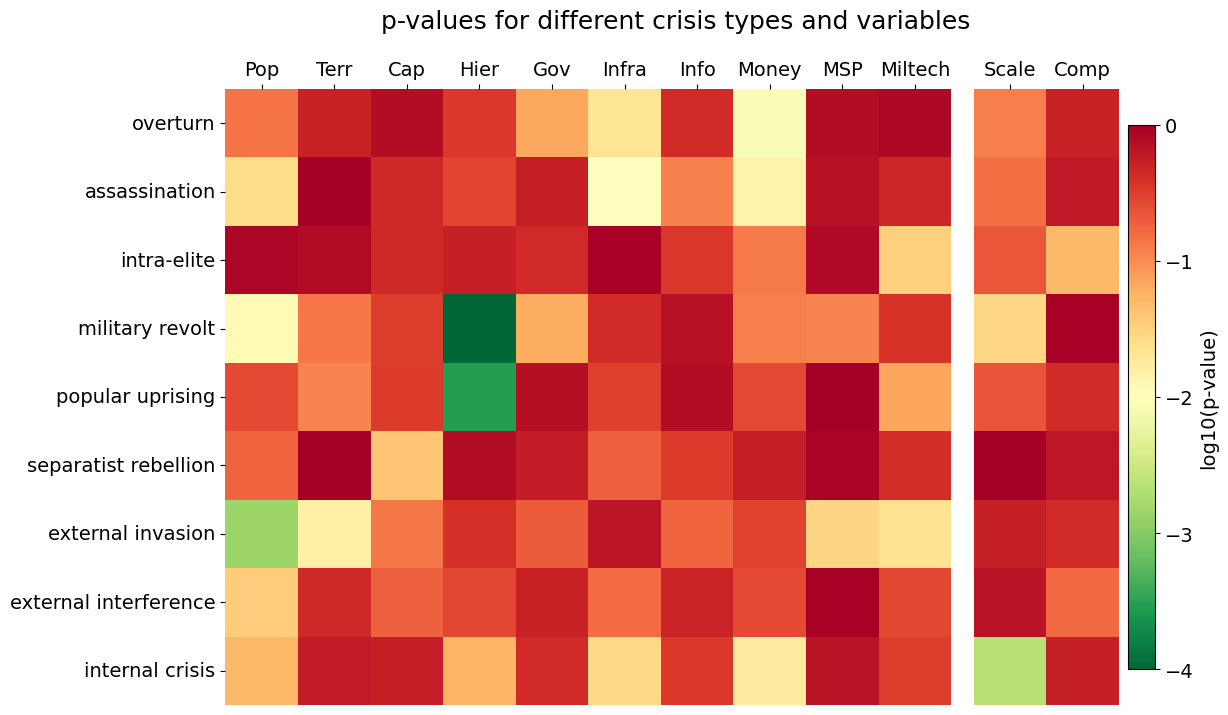

In [41]:
import matplotlib.gridspec as gridspec
import seaborn as sns

# Split data into main and side sections
main_data = regression_results[['Pop','Terr','Cap','Hier','Gov', 'Infrastructure', 'Information', 'Money', 'MSP', 'Miltech']].apply(np.log10)
side_data = regression_results[['Scale','Comp']].apply(np.log10)

# Create figure with custom horizontal layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

# Plot main heatmap
ax1 = fig.add_subplot(gs[0])
sns.heatmap(main_data, 
            cmap='RdYlGn_r', 
            alpha=1, 
            vmin=-4,
            ax=ax1,
            cbar=False,
            xticklabels=True)

# Plot side heatmap without y labels
ax2 = fig.add_subplot(gs[1])
sns.heatmap(side_data, 
            cmap='RdYlGn_r', 
            alpha=1, 
            vmin=-4,
            ax=ax2,
            cbar=False,
            yticklabels=False,
            xticklabels=True)

# Set labels only for main plot
labels = ['overturn', 'assassination', 'intra-elite', 'military revolt', 
          'popular uprising', 'separatist rebellion', 'external invasion', 
          'external interference', 'internal crisis']
labels_top = ['Pop', 'Terr', 'Cap','Hier','Gov', 'Infra', 'Info', 'Money', 'MSP', 'Miltech']
ax1.set_yticklabels(labels, rotation=0, fontsize=14)
ax1.set_xticklabels(labels_top, rotation=45, fontsize=14)

# Move x-axis labels to top for both plots
ax1.xaxis.set_ticks_position('top')
ax2.xaxis.set_ticks_position('top')
ax2.set_xticklabels(['Scale', 'Comp'], rotation=45, fontsize=14)

# Rotate x-axis labels for better readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')

# Create colorbar for the main heatmap
cbar = fig.colorbar(ax1.collections[0], ax=ax2, orientation='vertical')
cbar.set_label('log10(p-value)', fontsize=14)
cbar.set_ticks([-4, -3, -2, -1, 0])
# change font size of cbar and cbar labels
cbar.ax.tick_params(labelsize=14)


plt.tight_layout()
plt.suptitle('p-values for different crisis types and variables', fontsize=18)

In [42]:

# fit to linear regressor 
x_cols = ["Scale_1",'Comp','Hierarchy']
y_col = 'predecessor_assassination'
# rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
Xy = dataset_PT.scv_imputed
Xy = Xy[[y_col]+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]


logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.517464
         Iterations 5
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 1899
Model:                                 Logit   Df Residuals:                     1895
Method:                                  MLE   Df Model:                            3
Date:                       Mon, 16 Jun 2025   Pseudo R-squ.:               0.0005444
Time:                               13:32:48   Log-Likelihood:                -982.67
converged:                              True   LL-Null:                       -983.20
Covariance Type:                   nonrobust   LLR p-value:                    0.7842
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.1478      0.095      1.549      0.1

testing religion

In [43]:
import statsmodels.api as sm
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp','religion_family']
y_col = 'predecessor_assassination'
Xy = dataset_PT.scv_imputed
Xy.loc[~Xy.religion_family.isin(['Christianity','Zoroastrianism']),'religion_family'] = 'Other'
Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
Xy = pd.get_dummies(Xy, columns=['religion_family'], drop_first=False)
Xy.drop(columns=['religion_family_Other'], inplace=True)

Xy['intercept'] = 1
X = Xy.drop(columns=[y_col])
y = Xy[y_col]

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())



Optimization terminated successfully.
         Current function value: 0.517106
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 1899
Model:                                 Logit   Df Residuals:                     1894
Method:                                  MLE   Df Model:                            4
Date:                       Mon, 16 Jun 2025   Pseudo R-squ.:                0.001237
Time:                               13:32:48   Log-Likelihood:                -981.98
converged:                              True   LL-Null:                       -983.20
Covariance Type:                   nonrobust   LLR p-value:                    0.6567
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Scale_1     

Different kind of Scale and Comp plot

# Causes of polity collapse

Using the polity-preceeding-entities dataset show how the different types of succession sit on the Scale-Comp plot.

In [44]:
pred_df = download_data( "https://seshat-db.com/api/general/polity-preceding-entities/")
polity_df = download_data("https://seshat-db.com/api/core/polities/")

Downloaded 452 rows
Downloaded 862 rows


In [63]:
pred_df = pd.read_csv("..\\datasets\ALL_BATCHES_links_AllRegions_20250520_171230_withNames.csv")
pred_df['next_polity'] = pred_df['SuccessorPolityID']

pred_df['relationship_to_preceding_entity'] = pred_df['SuccessionType']

In [64]:
# pred_df['next_polity'] = pred_df.preceding_entity.apply(lambda x: polity_df.loc[polity_df.long_name == x].new_name.values[0] if x in polity_df.long_name.values else np.nan)
pred_df = pred_df.dropna(subset=['next_polity'])
dataset_100y.scv_imputed['polityEnd'] = dataset_100y.scv_imputed.PolityName.apply(lambda x: pred_df.loc[pred_df.next_polity == x].relationship_to_preceding_entity.values[0] if x in pred_df.next_polity.values else np.nan)

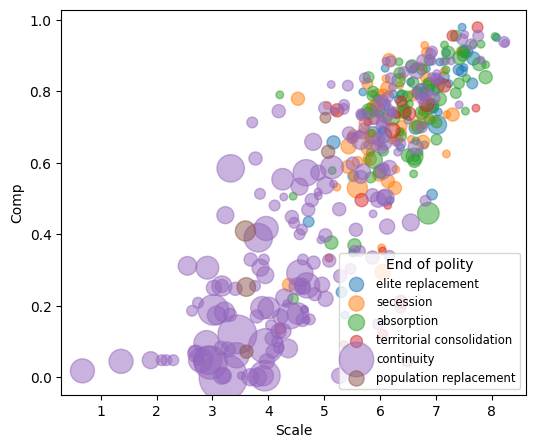

In [65]:
fig, ax = plt.subplots(figsize=(6, 5))
for rel in pred_df.relationship_to_preceding_entity.unique():
    if pd.isna(rel) or rel == 'unknown':
        continue
    dataset_plot = dataset_100y.scv_imputed
    dataset_plot = dataset_plot.loc[dataset_plot.polityEnd == rel].dropna(subset = ['Comp', 'Scale_1'])
    polity_group = dataset_plot.groupby('PolityName')
    
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    num_observations = polity_group.size()

    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        label = rel,
                        s=num_observations * 30,
                        alpha=0.5,
                        )



# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')

plt.legend(loc='lower right', fontsize='small', title='End of polity')

plt.show()

# Threads

Constuct threads of polities using the preceeding entitites dataset and plot their trajectories on the Scale-Comp plot.

In [74]:
pred_df['polity_start_year'] = pred_df.SourcePolityID.apply(lambda x: polity_df.loc[polity_df.name == x].start_year.values[0] if x in polity_df.name.values else np.nan)
pred_df['polity_end_year'] = pred_df.next_polity.apply(lambda x: polity_df.loc[polity_df.name == x].end_year.values[0] if x in polity_df.name.values else np.nan)
pred_df.columns


Index(['SourcePolityLongName', 'SuccessorPolityLongName', 'SourcePolityID',
       'SuccessorPolityID', 'SuccessionType', 'Rationale', 'Citation',
       'ChainOfThought', 'ModelID', 'ModelFingerprint', 'ModelTimestamp',
       'next_polity', 'relationship_to_preceding_entity', 'polity_start_year',
       'polity_end_year'],
      dtype='object')

In [78]:
pred_df_remove = pred_df.copy()
pred_df_remove = pred_df_remove.sort_values('polity_start_year', ascending = True)
pred_df_remove.reset_index(drop=True, inplace=True)
threads = []

while len(pred_df_remove) > 0:
    new_thread = []
    polity = pred_df_remove.iloc[0]
    while True:
        new_thread.append(polity.SourcePolityID)
        if pd.isna(polity.SuccessorPolityID):
            mask = (pred_df_remove.SourcePolityID == polity.SourcePolityID)&(pd.isna(pred_df_remove.SuccessorPolityID))
            pred_df_remove = pred_df_remove.loc[~mask]
            pred_df_remove.reset_index(drop=True, inplace=True)
            break
        pol_name = polity.SuccessorPolityID
        print(pol_name)
        mask = (pred_df_remove.SourcePolityID == polity.SourcePolityID)&(pred_df_remove.SuccessorPolityID == polity.SuccessorPolityID)
        pred_df_remove = pred_df_remove.loc[~mask]
        pred_df_remove.reset_index(drop=True, inplace=True)
        polity = pred_df_remove[pred_df_remove.SourcePolityID == pol_name]
        if len(polity) == 0:
            # polity proceeding entity exists in Seshat polity database but not in the preceding entities database
            new_thread.append(pol_name)
            break
        polity = polity.iloc[0]

    if len(pred_df_remove) < 2:
        break

    if len(new_thread) > 2:
        threads.append(new_thread)
        print('\n')

jp_jomon_2
jp_jomon_3
jp_jomon_4
jp_jomon_5
jp_jomon_6
jp_yayoi
jp_kofun
jp_asuka
jp_nara
jp_heian
jp_kamakura
jp_ashikaga
jp_sengoku_jidai
jp_azuchi_momoyama
jp_tokugawa_shogunate
jp_japanese_emp
jp_japan_contemporary


tr_konya_mnl
tr_konya_lnl
tr_konya_eca
tr_konya_lca
tr_konya_eba
tr_central_anatolia_mba
tr_hatti_old_k
tr_hatti_new_k
tr_neo_hittite_k
iq_neo_assyrian_emp
iq_neo_babylonian_emp
ir_achaemenid_emp
gr_macedonian_emp
ir_seleucid_emp
it_roman_rep_3
it_roman_principate
tr_roman_dominate
it_western_roman_emp
fr_merovingian_emp_1
fr_merovingian_emp_2
fr_merovingian_emp_3
fr_carolingian_emp_1
fr_carolingian_emp_2
fr_capetian_k_1
fr_capetian_k_2
fr_valois_k_1
fr_valois_k_2
fr_bourbon_k_1
fr_bourbon_k_2
fr_france_napoleonic
fr_france_modern_1
de_ns_germany
at_austrian_rep_2


iq_ubaid
iq_uruk
iq_early_dynastic
iq_akkad_emp


ir_susiana_formative
ir_susiana_archaic
ir_susiana_a
ir_susiana_b
ir_susiana_ubaid_1
ir_susiana_ubaid_2
ir_susa_1
ir_susa_2
ir_susa_3
ir_elam_1
ir_elam_2
ir

In [ ]:
# pred_df = download_data( "https://seshat-db.com/api/general/polity-preceding-entities/")
# polity_df = download_data('https://seshat-db.com/api/core/polities')

In [ ]:
# pred_df.loc[pred_df.polity_new_name == 'ug_buganda_k_2', 'preceding_entity'] = 'ug_buganda_k_1'
# pred_df.loc[pred_df.polity_new_name == 'gb_british_emp_1', 'preceding_entity'] = 'gb_england_tudor_and_early_stuart'
# pred_df.loc[pred_df.polity_new_name == 'us_hawaii_k', 'preceding_entity'] = 'Hawaii III'
# pred_df.loc[pred_df.polity_new_name == 'nkore_k_1', 'preceding_entity'] = 'Cwezi Dynasty'
# pred_df.loc[pred_df.polity_new_name == 'ye_qasimid_dyn', 'preceding_entity'] = 'Ottoman Empire II'
# pred_df.loc[pred_df.polity_new_name == 'de_hohenzollern_3', 'preceding_entity'] = 'Brandenburg-Prussia'


In [ ]:

# pred_df_remove = pred_df.copy()
# pred_df_remove = pred_df_remove.sort_values('polity_start_year', ascending = False)
# pred_df_remove.reset_index(drop=True, inplace=True)
# threads = []

# while len(pred_df_remove) > 0:
#     new_thread = []
#     polity = pred_df_remove.iloc[0]
#     while True:
#         new_thread.append(polity.polity_new_name)
#         if pd.isna(polity.preceding_entity):
#             mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pd.isna(pred_df_remove.preceding_entity))
#             pred_df_remove = pred_df_remove.loc[~mask]
#             pred_df_remove.reset_index(drop=True, inplace=True)
#             break
#         pol_name = polity_df.loc[polity_df.long_name == polity.preceding_entity, 'new_name']
#         if len(pol_name) == 0:
#             # look for slight variations in the name
#             # look for times where the polity database name includes the name of the succeeding entity
#             pol_name = polity_df.loc[polity_df.long_name.apply(lambda x: polity.preceding_entity.lower() in x.lower() if pd.notna(x) else x), 'new_name']
#             # look for times where the succeeding entity includes a name of the polity database name
#             if len(pol_name) == 0:
#                 pol_name = polity_df.loc[polity_df.long_name.apply(lambda x: x.lower() in polity.preceding_entity.lower() if pd.notna(x) else x), 'new_name']
#             # if still no match is found, remove the first row and break the loop
#             if len(pol_name) == 0:
#                 mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pred_df_remove.preceding_entity == polity.preceding_entity)
#                 pred_df_remove = pred_df_remove.loc[~mask]
#                 pred_df_remove.reset_index(drop=True, inplace=True)
#                 break
#         if len(pol_name)>1:
#             print(pol_name)
            
#         pol_name = pol_name.iloc[0]
#         print(pol_name)
#         mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pred_df_remove.preceding_entity == polity.preceding_entity)
#         pred_df_remove = pred_df_remove.loc[~mask]
#         pred_df_remove.reset_index(drop=True, inplace=True)
#         polity = pred_df_remove[pred_df_remove.polity_new_name == pol_name]
#         if len(polity) == 0:
#             # polity proceeding entity exists in Seshat polity database but not in the preceding entities database
#             new_thread.append(pol_name)
#             break
#         polity = polity.iloc[0]

#     if len(pred_df_remove) < 2:
#         break

#     if len(new_thread) > 2:
#         threads.append(new_thread[::-1])

cn_hmong_1
cn_qing_dyn_1
cn_ming_dyn
cn_yuan_dyn
mn_mongol_emp
mn_mongol_early
pg_orokaiva_pre_colonial
de_hohenzollern_2
de_hohenzollern_1
us_antebellum
gb_british_emp_1
ec_shuar_1
us_hawaii_3
us_hawaii_2
us_hawaii_1
ni_kwararafa
cn_qing_dyn_1
es_leon_k
th_ayutthaya
th_ayutthaya
us_hawaii_3
so_ajuran_sultanate
0    ug_nkore_k_2
0    ug_nkore_k_1
Name: new_name, dtype: object
ug_nkore_k_2
es_spanish_emp_1
es_castile_crown
ni_allada_k
ml_segou_k
in_mughal_emp
uz_timurid_emp
gh_akan
tr_ottoman_emp_2
tr_ottoman_emp_1
tr_ottoman_emirate
in_thanjavur_nayaks
in_vijayanagara_emp
in_delhi_sultanate
ni_allada_k
fr_bourbon_k_1
fr_valois_k_2
fr_valois_k_1
fr_capetian_k_2
fr_capetian_k_1
fr_carolingian_emp_2
fr_carolingian_emp_1
fr_merovingian_emp_3
fr_merovingian_emp_2
fr_merovingian_emp_1
0    in_bahmani_sultanate
0                  om_azd
0          uz_samanid_emp
Name: new_name, dtype: object
in_bahmani_sultanate
at_habsburg_1
us_oneota
us_cahokia_3
us_cahokia_2
tr_ottoman_emp_2
jp_azuchi_momo

In [79]:
# remove duplicate threads
all_threads = []
for thread in threads:
    if thread not in all_threads:
        all_threads.append(thread)
threads = all_threads


In [81]:
for dataset in [dataset_PT, dataset_FULL, dataset_100y]:
    dataset.scv_imputed['thread'] = np.nan
for t,thread in enumerate(threads):
    for dataset in [dataset_PT, dataset_FULL, dataset_100y]:
        mask = dataset.scv_imputed.PolityName.isin(thread)
        dataset.scv_imputed.loc[mask, 'thread'] = t

In [ ]:
print(len(dataset_100y.scv_imputed[dataset_100y.scv_imputed.thread.notna()].PolityName.unique()))
print(len(dataset_100y.scv_imputed[dataset_100y.scv_imputed.thread.isna()].PolityName.unique()))
print(len(dataset_100y.scv_imputed[dataset_100y.scv_imputed.NGA.notna()].PolityName.unique()))

632
154
369


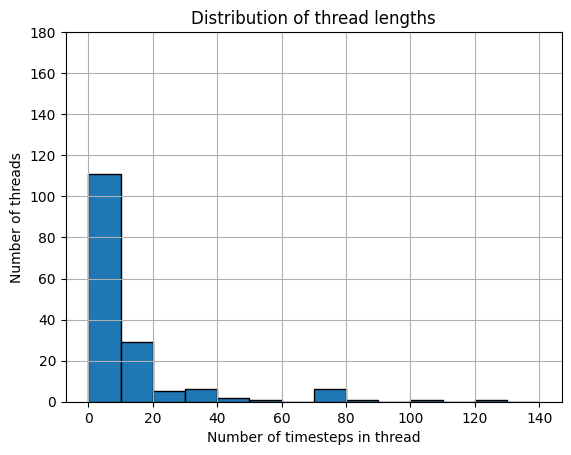

In [98]:
dataset_100y.scv_imputed.groupby('thread').size().hist(bins=np.arange(0, 150, 10), edgecolor='black')
plt.xlabel('Number of timesteps in thread')
plt.ylabel('Number of threads')
plt.title('Distribution of thread lengths')
plt.ylim(0, 180)
plt.show()

['jp_jomon_1', 'jp_jomon_2', 'jp_jomon_3', 'jp_jomon_4', 'jp_jomon_5', 'jp_jomon_6', 'jp_yayoi', 'jp_kofun', 'jp_asuka', 'jp_nara', 'jp_heian', 'jp_kamakura', 'jp_ashikaga', 'jp_sengoku_jidai', 'jp_azuchi_momoyama', 'jp_tokugawa_shogunate', 'jp_japanese_emp', 'jp_japan_contemporary']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


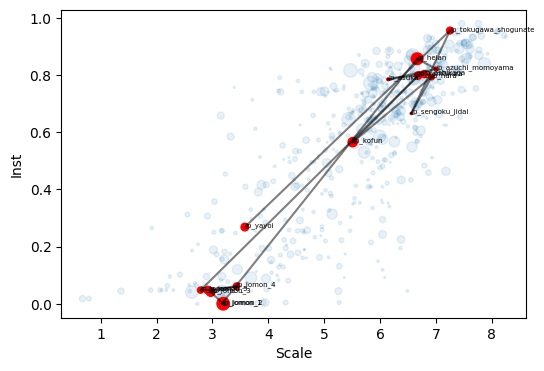

['tr_konya_enl', 'tr_konya_mnl', 'tr_konya_lnl', 'tr_konya_eca', 'tr_konya_lca', 'tr_konya_eba', 'tr_central_anatolia_mba', 'tr_hatti_old_k', 'tr_hatti_new_k', 'tr_neo_hittite_k', 'iq_neo_assyrian_emp', 'iq_neo_babylonian_emp', 'ir_achaemenid_emp', 'gr_macedonian_emp', 'ir_seleucid_emp', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp', 'fr_merovingian_emp_1', 'fr_merovingian_emp_2', 'fr_merovingian_emp_3', 'fr_carolingian_emp_1', 'fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2', 'fr_france_napoleonic', 'fr_france_modern_1', 'de_ns_germany', 'at_austrian_rep_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


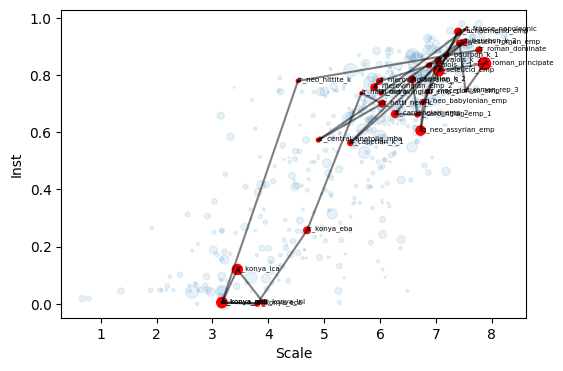

['iq_so_mesopotamia_nl', 'iq_ubaid', 'iq_uruk', 'iq_early_dynastic', 'iq_akkad_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


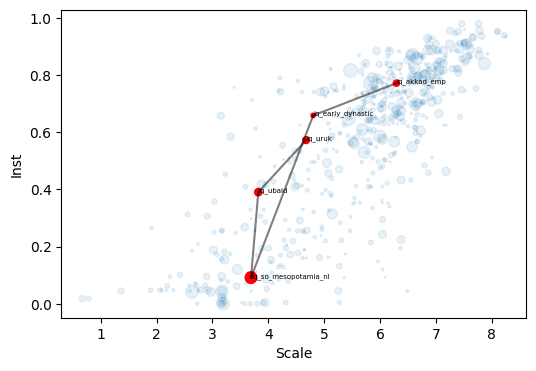

['ir_susiana_pre_ceramic', 'ir_susiana_formative', 'ir_susiana_archaic', 'ir_susiana_a', 'ir_susiana_b', 'ir_susiana_ubaid_1', 'ir_susiana_ubaid_2', 'ir_susa_1', 'ir_susa_2', 'ir_susa_3', 'ir_elam_1', 'ir_elam_2', 'ir_elam_3', 'ir_elam_4', 'ir_elam_5', 'ir_elam_6', 'ir_elam_7', 'ir_elam_8', 'ir_neo_elam_1', 'ir_neo_elam_2', 'iq_neo_assyrian_emp', 'ir_median_emp', 'ir_achaemenid_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


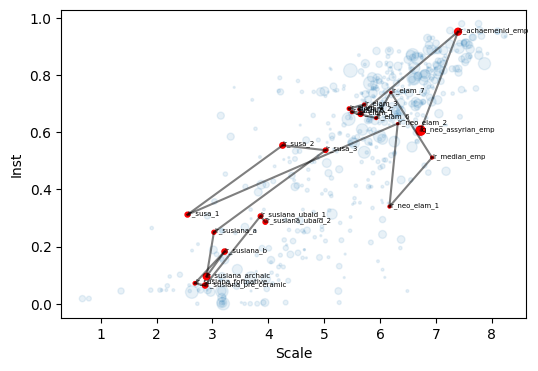

['pk_kachi_enl', 'pk_kachi_lnl', 'pk_kachi_ca', 'pk_kachi_pre_urban', 'pk_kachi_urban_1', 'pk_kachi_urban_2', 'pk_kachi_post_urban', 'pk_kachi_proto_historic', 'ir_achaemenid_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


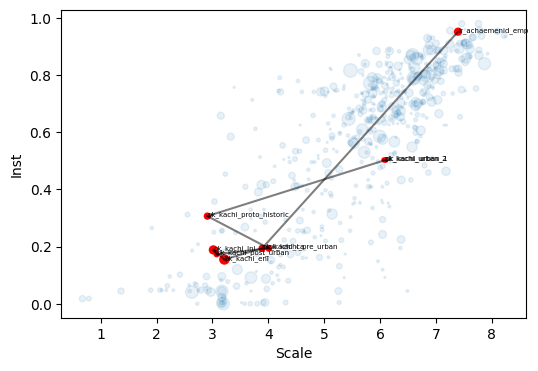

['cn_peiligang', 'cn_yangshao', 'cn_longshan', 'cn_erlitou', 'cn_erligang', 'cn_late_shang_dyn', 'cn_western_zhou_dyn', 'cn_qi_spring_autumn', 'cn_qi_warring_states', 'cn_qin_emp', 'cn_western_han_dyn', 'cn_eastern_han_dyn', 'cn_wei_k', 'cn_western_jin_dyn', 'cn_northern_wei_dyn']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


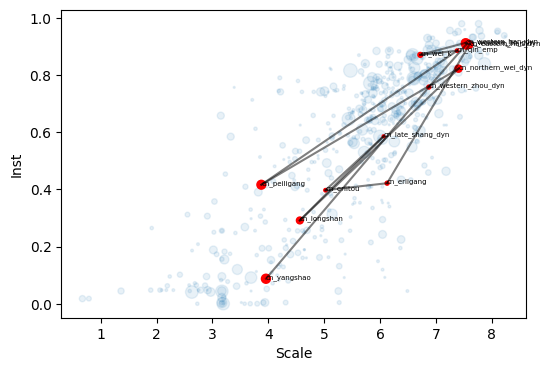

['gr_crete_nl', 'gr_crete_pre_palace', 'gr_crete_old_palace', 'gr_crete_new_palace', 'gr_crete_mono_palace', 'gr_crete_post_palace_1', 'gr_crete_post_palace_2', 'gr_crete_geometric', 'gr_crete_archaic', 'gr_crete_classical', 'gr_crete_hellenistic', 'it_roman_rep_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


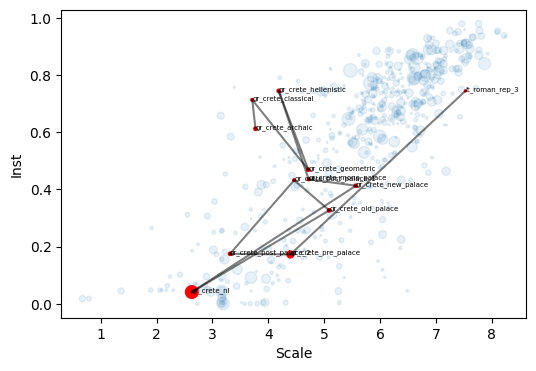

['in_ganga_nl', 'in_ganga_ca', 'in_mahajanapada', 'in_mauryan_emp', 'in_sunga_emp', 'in_kanva_dyn', 'in_satavahana_emp', 'in_vakataka_k', 'in_maukhari_dyn', 'in_harsha_emp', 'in_kannauj_varman_dyn', 'in_gurjara_pratihara_dyn', 'in_chandela_k', 'in_delhi_sultanate', 'in_mughal_emp', 'gb_british_emp_2', 'ca_canada_dominion']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


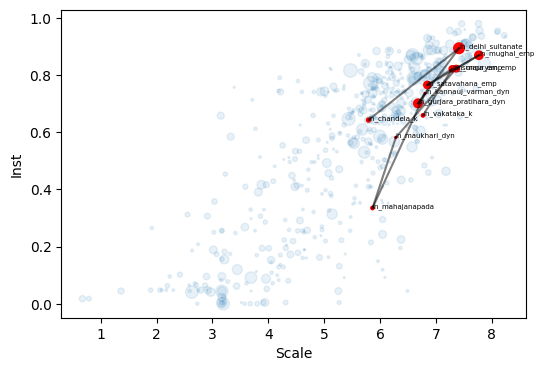

['mx_basin_of_mexico_1', 'mx_basin_of_mexico_2', 'mx_basin_of_mexico_3', 'mx_basin_of_mexico_4', 'mx_basin_of_mexico_5', 'mx_basin_of_mexico_6', 'mx_basin_of_mexico_7', 'mx_basin_of_mexico_8', 'mx_toltec', 'mx_basin_of_mexico_10', 'mx_aztec_emp', 'es_spanish_emp_1', 'pt_portuguese_emp_2', 'br_brazil_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


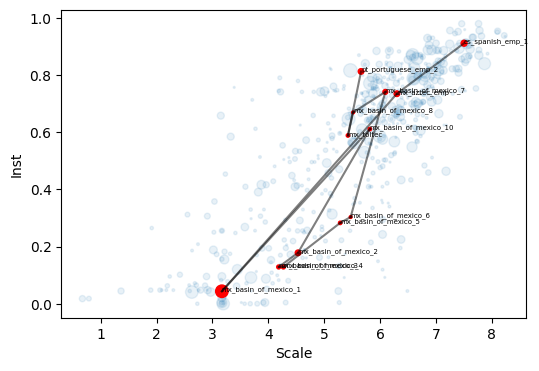

['eg_badarian', 'eg_naqada_1', 'eg_naqada_2', 'eg_naqada_3', 'eg_dynasty_1', 'eg_dynasty_2', 'eg_old_k_1', 'eg_old_k_2', 'eg_regions', 'eg_middle_k', 'eg_thebes_hyksos', 'eg_new_k_1', 'eg_new_k_2', 'eg_thebes_libyan', 'eg_kushite', 'eg_saite', 'ir_achaemenid_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


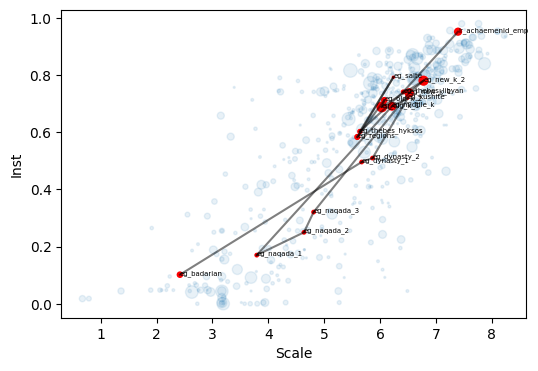

['it_latium_ca', 'it_latium_ba', 'it_latium_ia', 'it_roman_k', 'it_roman_rep_1', 'it_roman_rep_2', 'it_roman_rep_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


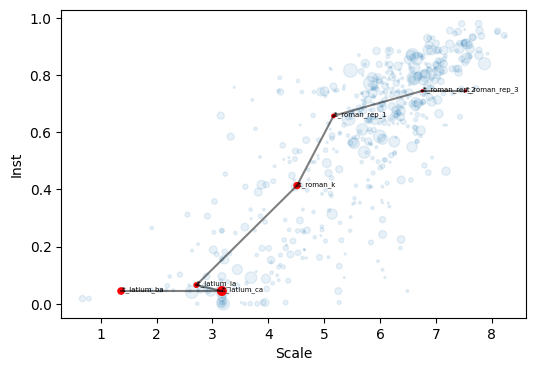

['fr_beaker_eba', 'fr_atlantic_complex', 'fr_hallstatt_a_b1', 'fr_hallstatt_b2_3', 'fr_hallstatt_c', 'fr_hallstatt_d', 'fr_la_tene_a_b1', 'fr_la_tene_b2_c1', 'fr_la_tene_c2_d', 'it_roman_principate']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


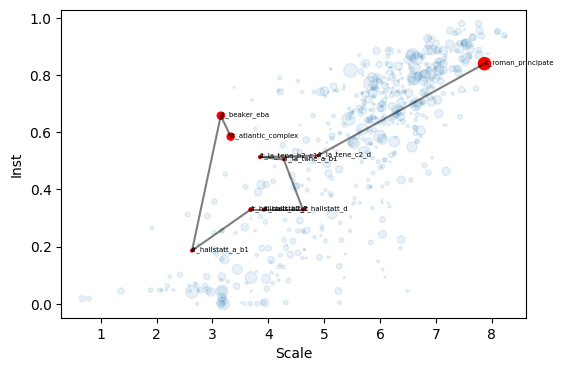

['pa_monagrillo', 'pa_la_mula_sarigua', 'pa_cocle_1', 'pa_cocle_2', 'pa_cocle_3', 'es_spanish_emp_1', 'es_spanish_emp_2', 'es_spanish_emp_3', 'cu_cuba_rep_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


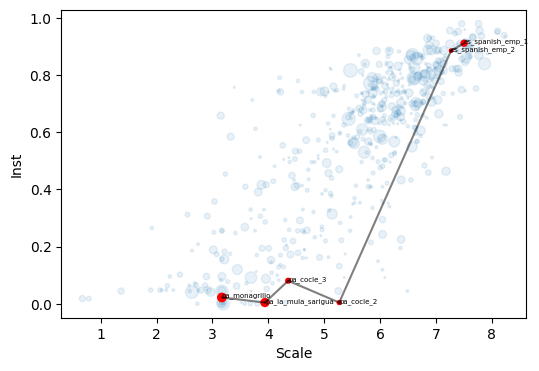

['iq_ur_dyn_3', 'iq_isin_larsa', 'iq_babylonia_1', 'iq_babylonia_2', 'iq_isin_dynasty2', 'iq_bazi_dyn']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


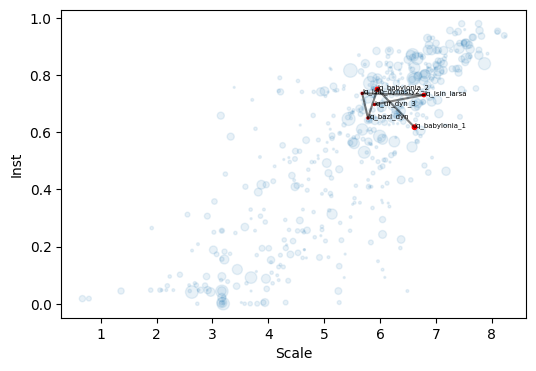

['il_canaan', 'lb_phoenician_emp', 'gr_macedonian_emp', 'gr_antigonid_emp', 'it_roman_rep_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


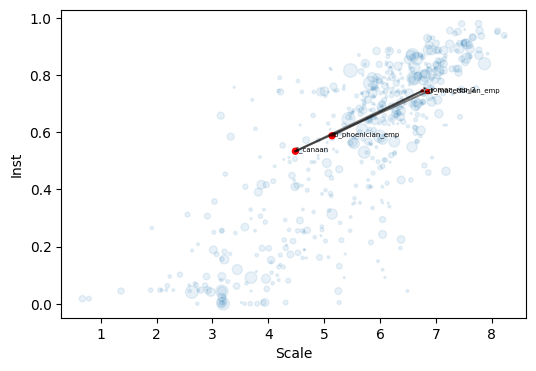

['ni_nok_1', 'ni_nok_2', 'ni_proto_yoruboid', 'ni_proto_yoruba', 'ni_formative_yoruba', 'ni_yoruba_classic', 'ni_oyo_emp_1', 'ni_oyo_emp_2', 'ni_sokoto_cal', 'fr_france_modern_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


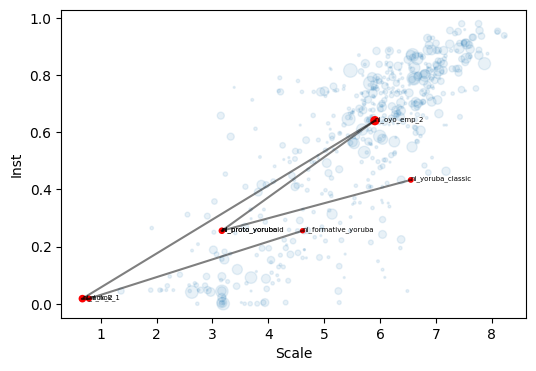

['mx_tierras_largas', 'mx_san_jose', 'mx_rosario', 'mx_monte_alban_1_early', 'mx_monte_alban_1_late', 'mx_monte_alban_2', 'mx_monte_alban_3_a', 'mx_monte_alban_3_b_4', 'mx_monte_alban_5_a', 'mx_monte_alban_5_b', 'es_spanish_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


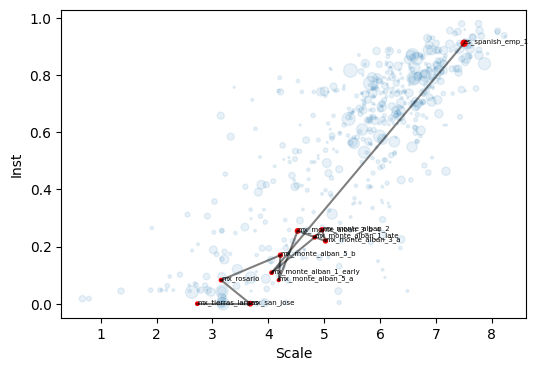

C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


['mn_hunnu_early', 'mn_hunnu_emp', 'mn_hunnu_late', 'mn_xianbei', 'cn_northern_wei_dyn']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


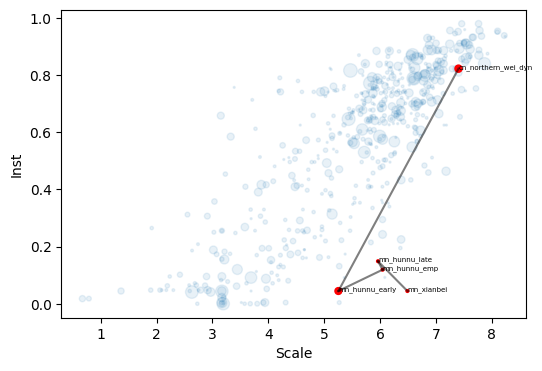

['kh_cambodia_ba', 'kh_cambodia_ia', 'kh_funan_1', 'kh_funan_2', 'kh_chenla', 'kh_angkor_1', 'kh_angkor_2', 'kh_angkor_3', 'kh_khmer_k', 'th_ayutthaya']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


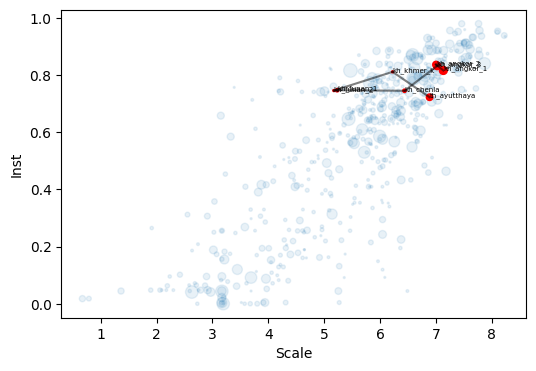

['us_woodland_1', 'us_woodland_2', 'us_woodland_3', 'us_woodland_4', 'us_woodland_5', 'us_emergent_mississippian_1', 'us_emergent_mississippian_2', 'us_cahokia_1', 'us_cahokia_2', 'us_cahokia_3', 'us_oneota', 'us_early_illinois_confederation', 'us_late_illinois_confederation', 'us_antebellum', 'us_united_states_of_america_reconstruction', 'us_united_states_of_america_contemporary']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


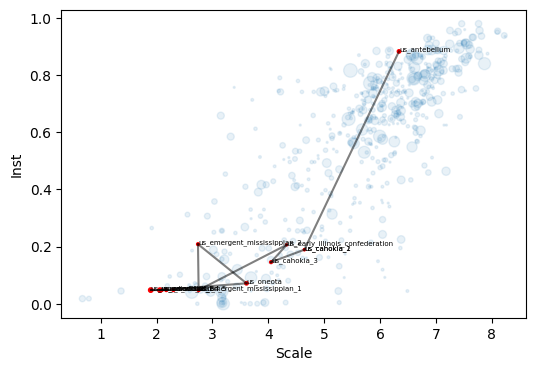

['pe_cuzco_1', 'pe_cuzco_2', 'pe_cuzco_3', 'pe_wari_emp', 'pe_cuzco_5', 'pe_cuzco_6', 'pe_inca_emp', 'es_spanish_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


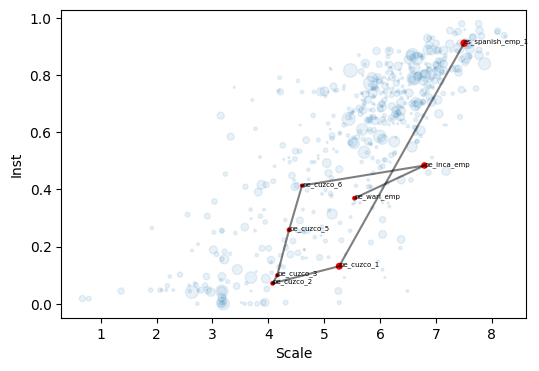

['gr_macedonian_emp', 'tr_lysimachus_k', 'ir_seleucid_emp', 'ir_parthian_emp_1', 'iq_parthian_emp_2', 'ir_sassanid_emp_1', 'ir_sassanid_emp_2', 'sa_rashidun_dyn', 'sy_umayyad_cal', 'iq_abbasid_cal_1', 'ir_buyid_confederation', 'ir_seljuk_sultanate', 'iq_abbasid_cal_2', 'ir_il_khanate', 'ir_ak_koyunlu', 'ir_safavid_emp', 'tr_ottoman_emp_3', 'tr_ottoman_emp_4', 'tr_turkey_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


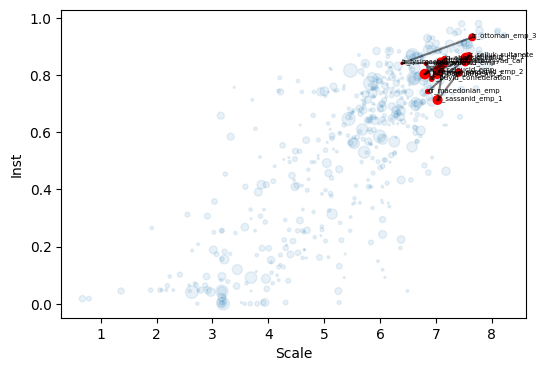

['ir_seleucid_emp', 'af_greco_bactrian_k', 'af_tocharian', 'af_kushan_emp', 'ir_sassanid_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


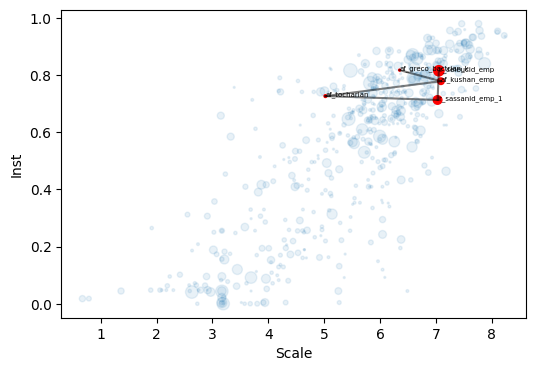

['in_pandya_emp_1', 'in_kalabhra_dyn', 'in_badami_chalukya_emp', 'in_rashtrakuta_emp', 'in_kalyani_chalukya_emp', 'in_kakatiya_dyn', 'in_delhi_sultanate', 'in_bahmani_sultanate', 'in_ahmadnagar_sultanate', 'in_mughal_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


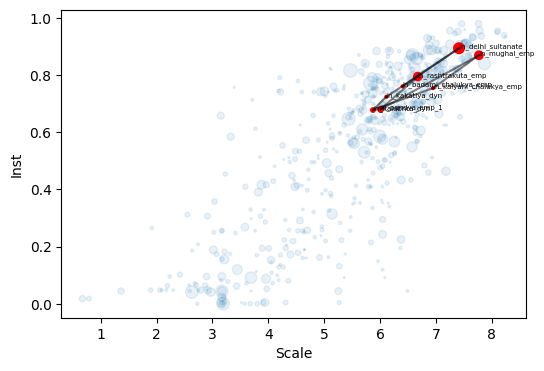

['in_cholas_1', 'in_kalabhra_dyn', 'in_pandya_emp_2', 'in_chola_emp', 'in_pandya_emp_3', 'in_delhi_sultanate', 'bd_bengal_sultanate', 'bd_twelve_bhuyans', 'in_mughal_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


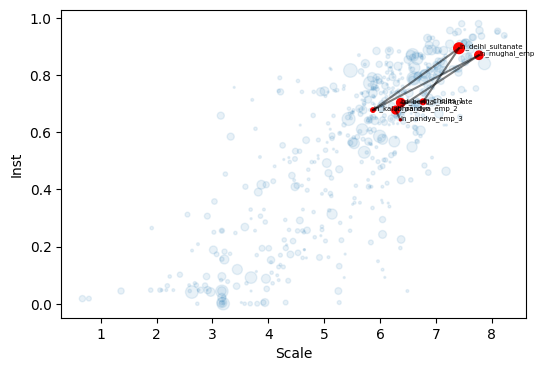

['sl_anuradhapura_1', 'sl_anuradhapura_2', 'sl_anuradhapura_3', 'sl_anuradhapura_4', 'in_chola_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


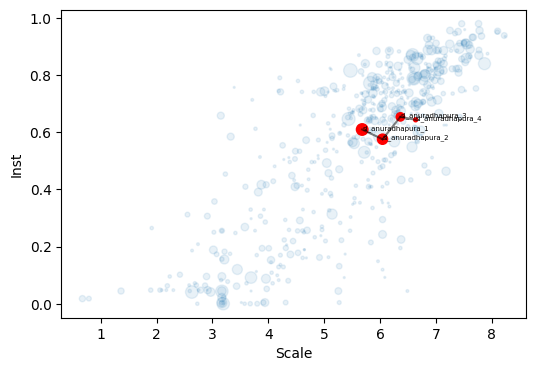

C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


['af_greco_bactrian_k', 'pk_indo_greek_k', 'af_kushan_emp', 'in_gupta_emp', 'in_maukhari_dyn']


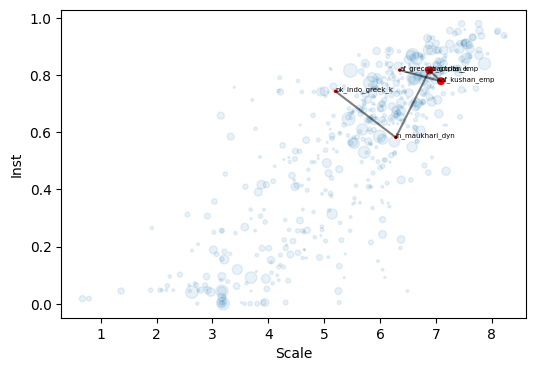

['ml_jenne_jeno_1', 'ml_jenne_jeno_2', 'ml_jenne_jeno_3', 'ml_jenne_jeno_4', 'ml_mali_emp', 'ml_songhai_1', 'ml_songhai_2', 'ma_saadi_sultanate', 'mo_alawi_dyn_1', 'mo_alawi_dyn_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


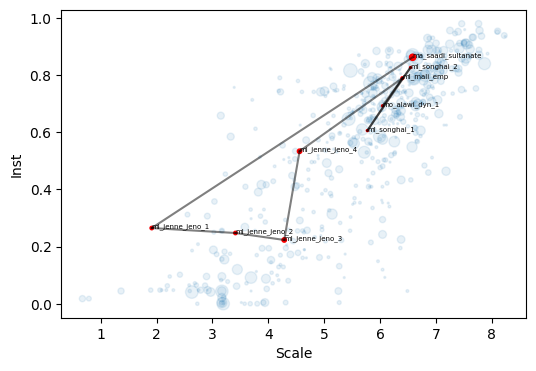

['in_post_mauryan_k', 'pk_indo_greek_k', 'pk_indo_parthian_k', 'af_kushan_emp', 'af_kidarite_k', 'af_hephthalite_emp', 'kg_western_turk_khaganate', 'cn_tang_dyn_1', 'cn_tang_dyn_2', 'cn_five_dyn', 'cn_northern_song_dyn', 'cn_southern_song_dyn', 'cn_yuan_dyn', 'mn_mongol_late', 'cn_qing_dyn_1', 'cn_qing_dyn_2', 'cn_chinese_rep', 'cn_chinese_peoples_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


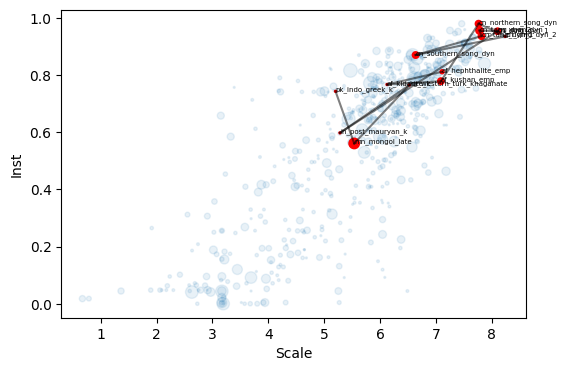

['et_aksum_emp_1', 'et_aksum_emp_2', 'et_aksum_emp_3', 'et_habesha', 'et_zagwe', 'et_ethiopian_k', 'et_ethiopian_k_2', 'et_ethiopian_k_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


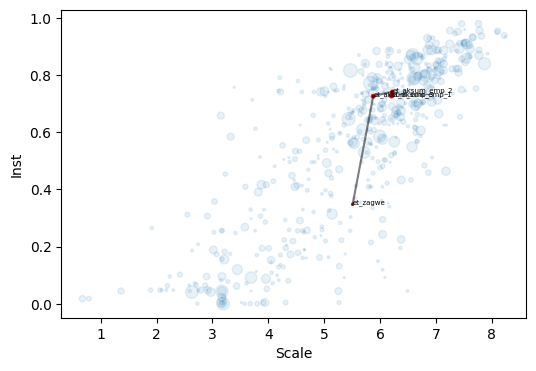

['kr_goguryeo_k', 'kr_balhae_k', 'mn_khitan_1', 'cn_later_great_jin', 'mn_mongol_emp', 'cn_yuan_dyn', 'cn_ming_dyn', 'cn_qing_dyn_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


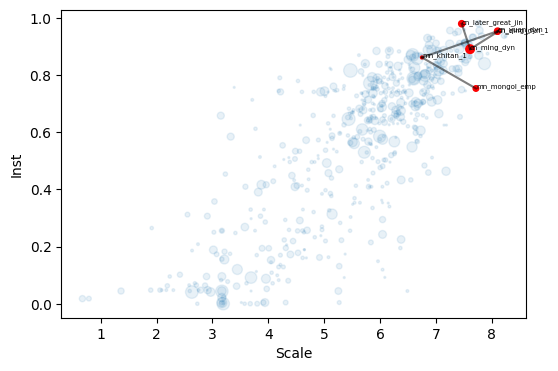

['pk_western_satraps', 'in_gupta_emp', 'in_vanga_k', 'in_gauda_k', 'in_harsha_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


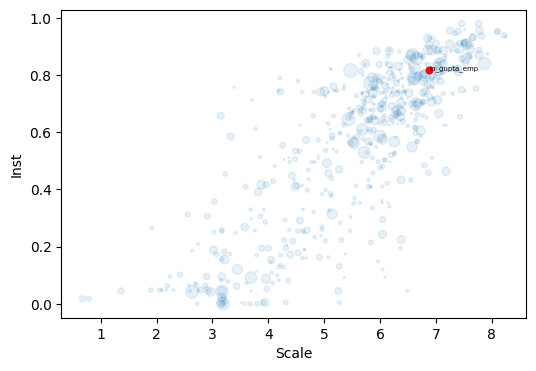

['bf_west_burkina_faso_yellow_5', 'bf_west_burkina_faso_yellow_6', 'bf_west_burkina_faso_red_1', 'bf_west_burkina_faso_red_2', 'bf_west_burkina_faso_red_4', 'bf_mossi_k_1', 'fr_france_modern_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


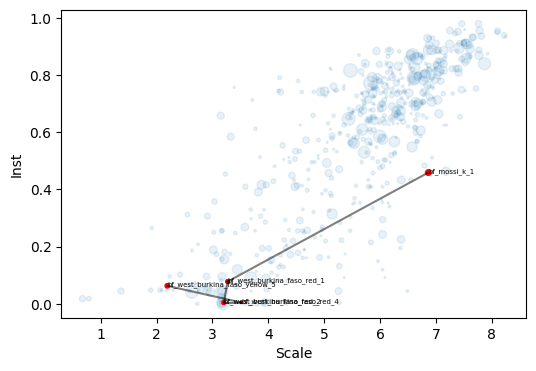

['bo_titicaca_late_formative', 'bo_tiwanaku_1', 'bo_tiwanaku_2', 'bo_titicaca_early_pacajes', 'pe_inca_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


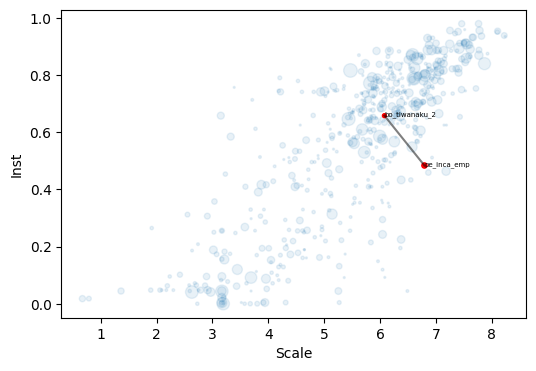

C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


['mr_wagadu_1', 'mr_wagadu_2', 'ma_almoravid_dyn', 'ma_almohad_emp', 'ma_marinid_dyn', 'ma_wattasid_dyn', 'ma_saadi_sultanate']


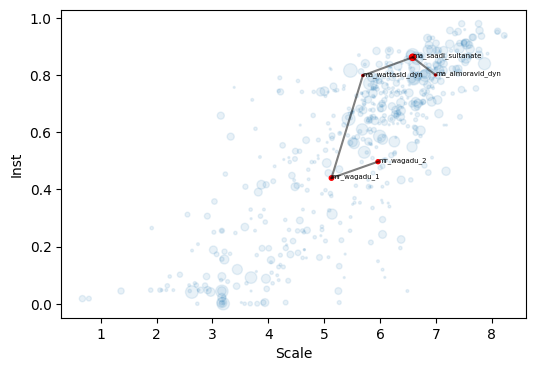

['tr_roman_dominate', 'tr_east_roman_emp', 'tr_byzantine_emp_1', 'tr_byzantine_emp_2', 'tr_byzantine_emp_3', 'gr_achaea_principality', 'tr_ottoman_emp_1', 'tr_ottoman_emp_2', 'tr_ottoman_emp_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


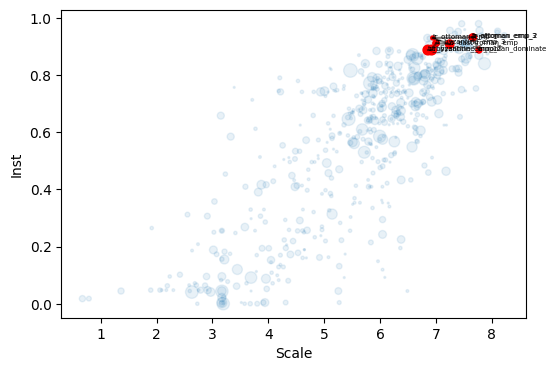

['hu_hun_k', 'rs_gepid_k', 'it_lombard_k', 'fr_carolingian_emp_1', 'de_east_francia', 'de_empire_1', 'de_empire_2', 'de_empire_3', 'at_habsburg_1', 'at_habsburg_2', 'at_interwar_austria', 'de_ns_germany']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


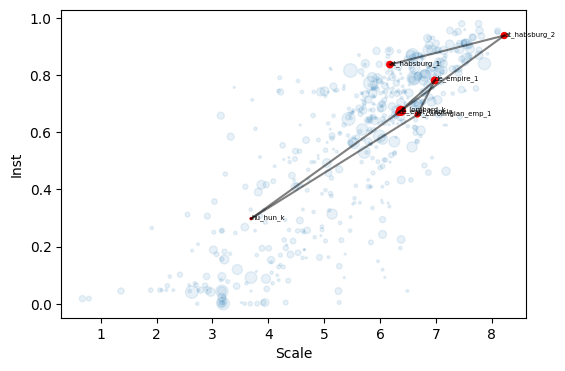

['it_western_roman_emp', 'gb_brythonic_k', 'gb_anglo_saxon_1', 'gb_danelaw', 'gb_anglo_saxon_2', 'gb_england_norman', 'gb_england_plantagenet', 'gb_tudor_stuart', 'gb_british_emp_1', 'gb_british_emp_2', 'sl_sri_lanka']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


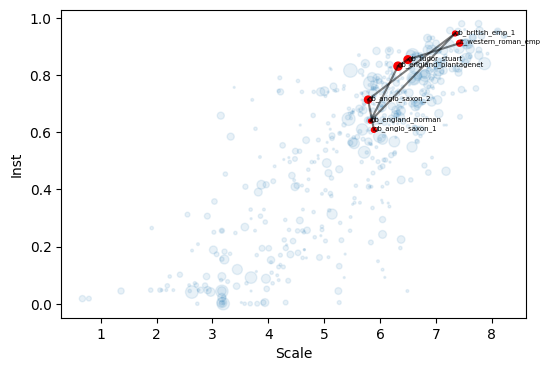

['it_western_roman_emp', 'pt_suebi_k', 'es_visigothic_k', 'es_asturias_k', 'es_leon_k', 'pt_portugal_k', 'pt_portuguese_emp_1', 'es_spanish_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


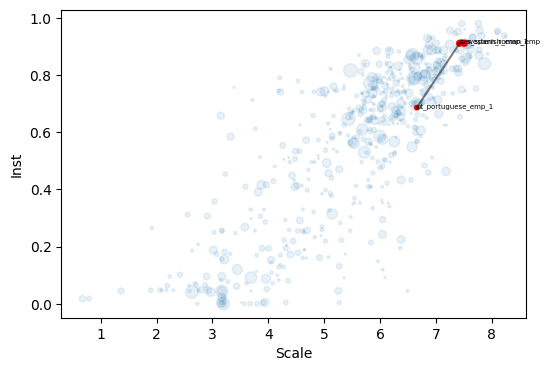

['it_western_roman_emp', 'es_visigothic_k', 'sy_umayyad_cal', 'es_cordoba_emirate', 'es_cordoba_cal', 'es_taifas', 'es_castile_k', 'es_castile_crown', 'es_spanish_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


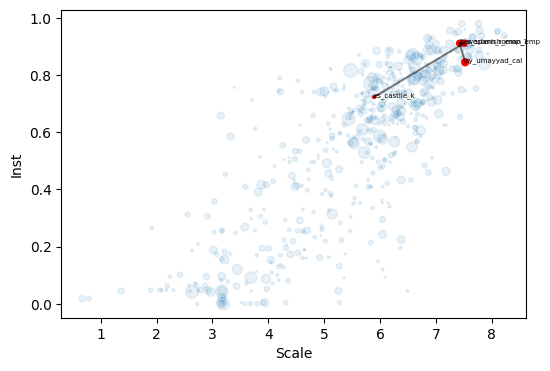

['it_ravenna_exarchate', 'it_st_peter_rep_1', 'it_st_peter_rep_2', 'it_papal_state_1', 'it_republic_restoration', 'it_papal_state_2', 'it_papal_state_3', 'it_papal_state_4', 'fr_bourbon_k_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


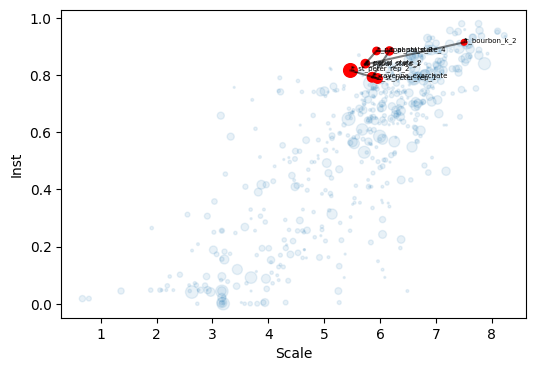

['kg_western_turk_khaganate', 'ru_khazar_emp', 'bg_volga_k', 'ru_golden_horde', 'ru_sibir_khanate', 'ru_moskva_rurik_dyn', 'ru_romanov_dyn_1', 'ru_romanov_dyn_2', 'su_finland_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


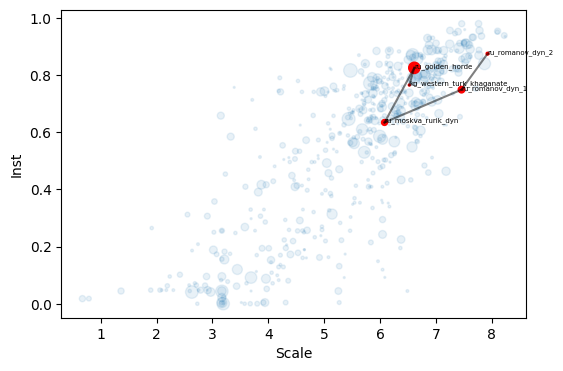

['ni_kwararafa', 'ni_sokoto_cal', 'de_hohenzollern_3', 'de_weimar_rep', 'de_ns_germany']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


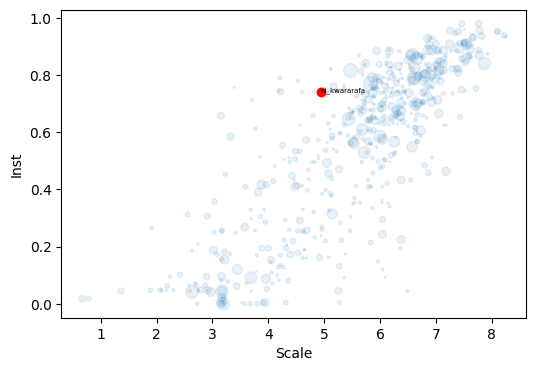

['si_pre_sape', 'si_sape', 'si_mane_emp', 'si_early_modern_interior', 'gb_british_emp_2', 'ei_ireland_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


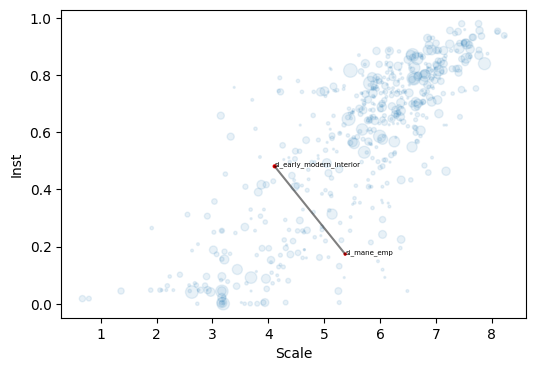

['mn_shiwei', 'mn_khitan_1', 'tm_kara_khitai_khanate', 'mn_mongol_emp', 'uz_chagatai_khanate', 'uz_timurid_emp', 'in_mughal_emp']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


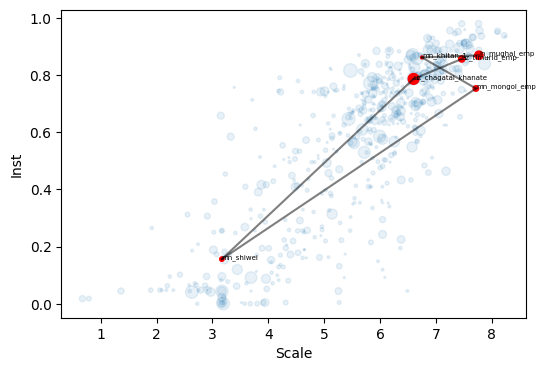

['mn_shiwei', 'mn_mongol_early', 'mn_mongol_emp', 'ru_golden_horde', 'ru_astrakhan_khanate', 'ru_moskva_rurik_dyn']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


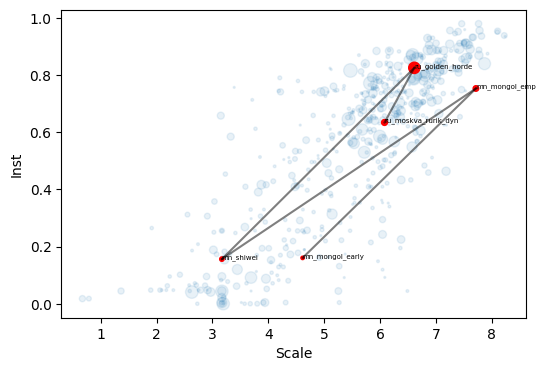

['ru_khazar_emp', 'ua_kievan_rus', 'ru_golden_horde', 'ru_kazan_khanate', 'ru_moskva_rurik_dyn']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


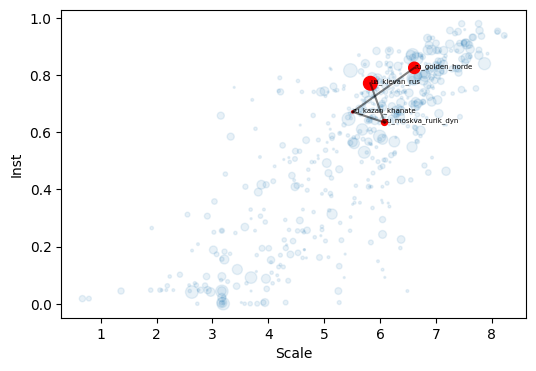

['mn_turk_khaganate_2', 'mn_uygur_khaganate', 'cn_ganzhou_k', 'cn_xixia', 'mn_mongol_emp', 'ir_il_khanate', 'ir_jayarid_khanate', 'uz_timurid_emp', 'uz_shaybanid_k', 'uz_janid_dyn', 'af_durrani_emp', 'af_afghanistan_emirate', 'af_afghanistan_k', 'af_afghanistan_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


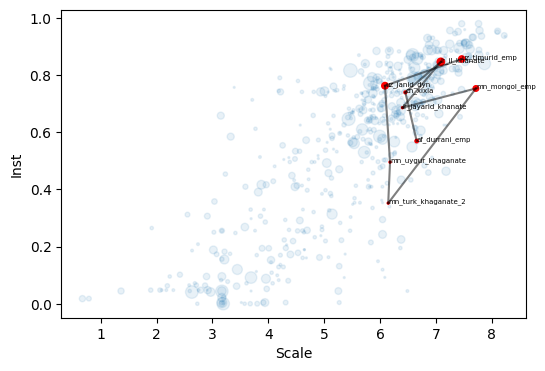

['zi_toutswe', 'zi_great_zimbabwe', 'zi_torwa_rozvi', 'gb_british_emp_2', 'cg_congo_democratic_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


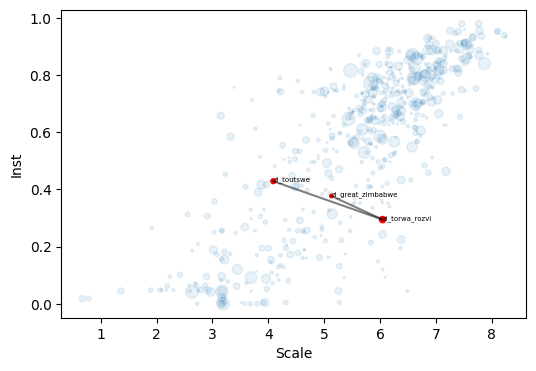

['iq_abbasid_cal_1', 'eg_thulunid_ikhshidid', 'tn_fatimid_cal', 'eg_ayyubid_sultanate', 'eg_mamluk_sultanate_1', 'eg_mamluk_sultanate_2', 'eg_mamluk_sultanate_3', 'tr_ottoman_emp_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


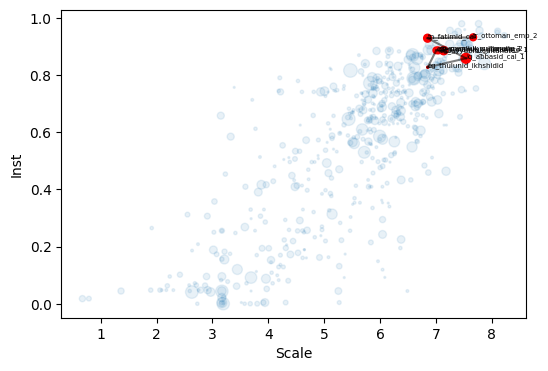

['iq_abbasid_cal_1', 'ir_saffarid_emp', 'af_ghaznavid_emp', 'ir_seljuk_sultanate', 'tr_rum_sultanate', 'tr_candar_bey', 'tr_ottoman_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


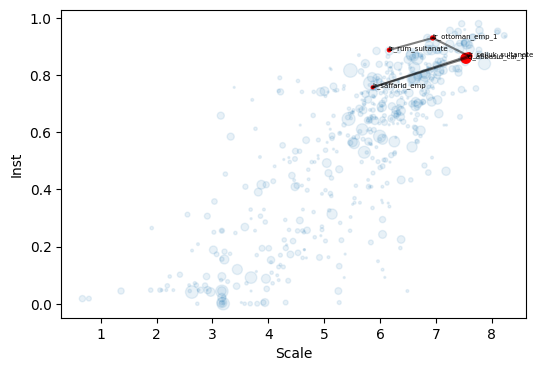

['iq_abbasid_cal_1', 'tn_fatimid_cal', 'tn_zirid_dyn', 'it_sicily_k_1', 'it_sicily_k_2', 'es_aragon_crown', 'es_spanish_emp_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


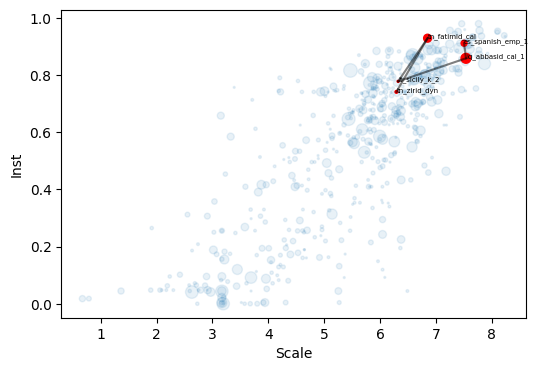

['dk_viking_settlements', 'sv_swedish_k_1', 'sv_kalmar_union', 'sv_swedish_k_2', 'sv_swedish_emp', 'sv_united_k_sweden_and_norway', 'no_norway_k_modern', 'de_ns_germany']
['dk_viking_settlements', 'no_norway_k_1', 'no_norway_k_2', 'sv_kalmar_union', 'dk_denmark_norway', 'dk_danish_emp_modern', 'dk_danish_k_modern']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

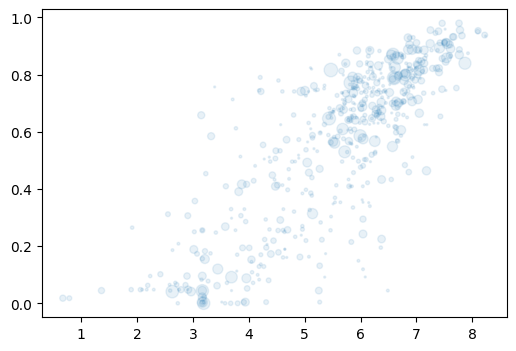

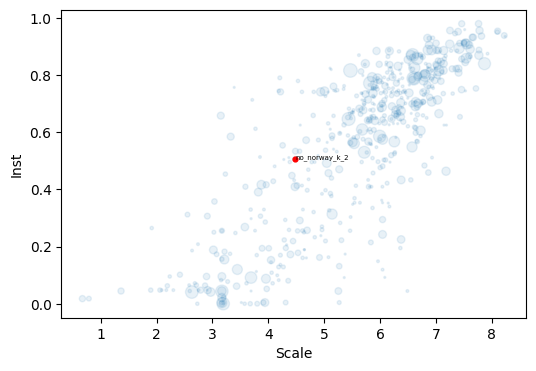

['cz_moravia_k', 'cz_bohemian_duc', 'cz_bohemian_k_1', 'cz_bohemian_k_2', 'at_habsburg_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


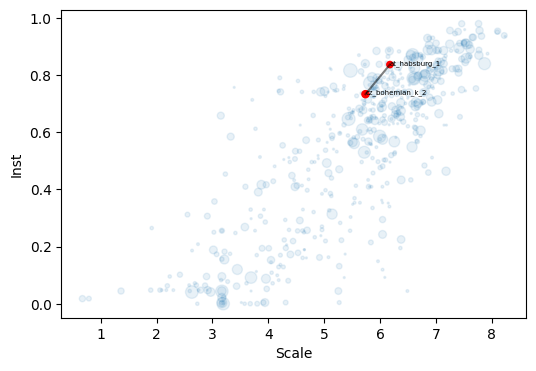

['us_chaco_bonito_1', 'us_chaco_bonito_2', 'us_chaco_bonito_3', 'us_chaco_mcelmo', 'us_chaco_mesa_verde']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


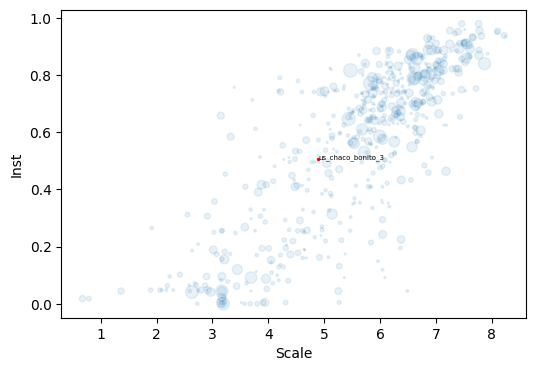

['ua_kievan_rus', 'ua_galicia_volhynia_principality', 'pl_piast_dyn_2', 'pl_jagiellonian_dyn', 'pl_poland_lithuania_commonwealth', 'de_hohenzollern_2', 'de_hohenzollern_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


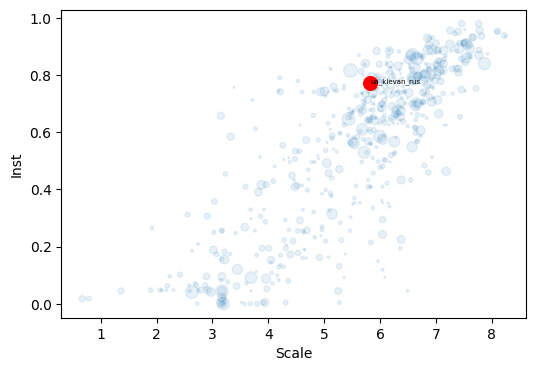

['ug_early_nyoro', 'ug_bunyoro_k_1', 'ug_bunyoro_k_2', 'gb_british_emp_2', 'id_indonesian_rep']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


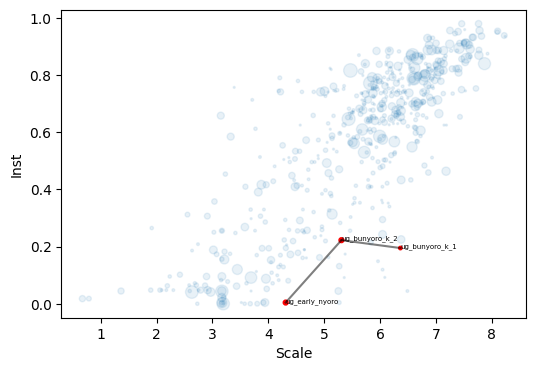

['bd_chandra_dyn', 'bd_yadava_varman_dyn', 'bd_sena_dyn', 'bd_deva_dyn', 'in_delhi_sultanate']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


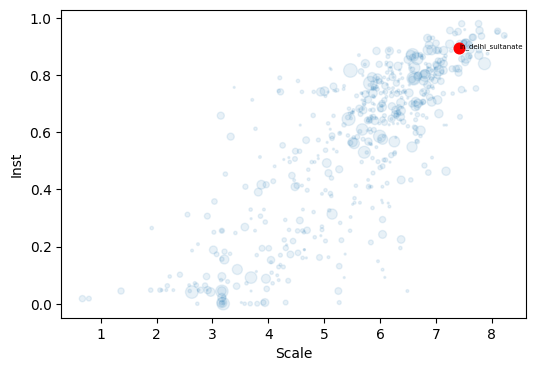

['in_kalyani_chalukya_emp', 'in_kalachuri_emp', 'in_kalyani_chalukya_emp', 'in_hoysala_k', 'in_delhi_sultanate']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


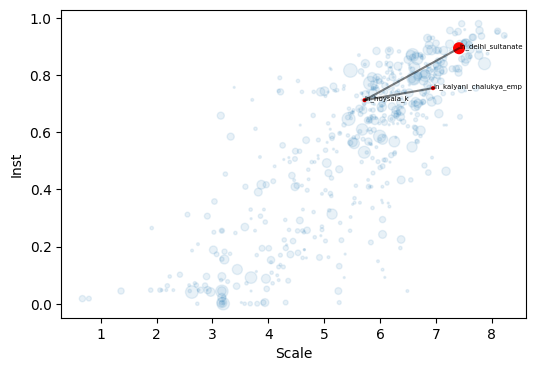

['us_hawaii_1', 'us_hawaii_2', 'us_hawaii_3', 'us_kamehameha_k', 'us_hawaii_k', 'us_united_states_of_america_reconstruction']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


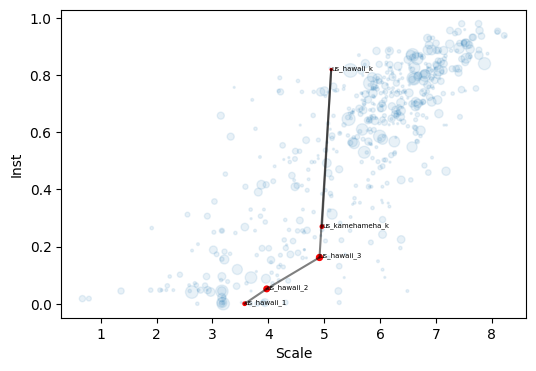

['ua_russian_principate', 'ru_golden_horde', 'ru_crimean_khanate', 'ru_romanov_dyn_2', 'ru_soviet_union', 'ru_russian_federation']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


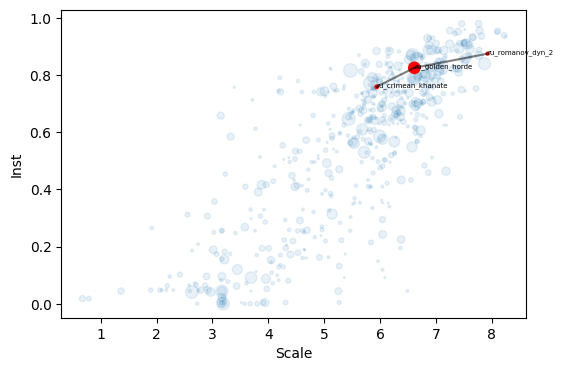

['mw_pre_maravi', 'mw_early_maravi', 'mw_northern_maravi_k', 'mw_maravi_emp', 'gb_british_emp_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


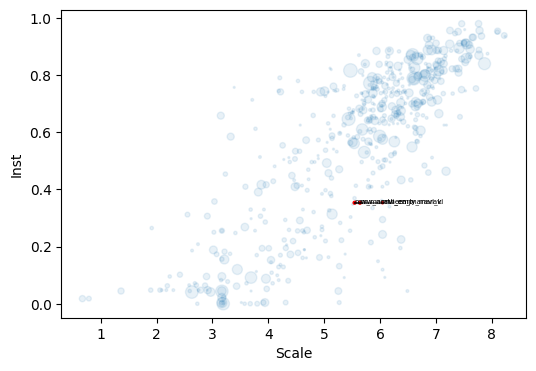

['cy_cyprus_k', 'it_venetian_rep_3', 'it_venetian_rep_4', 'at_habsburg_2', 'at_austro_hungarian_emp', 'at_interwar_austria']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


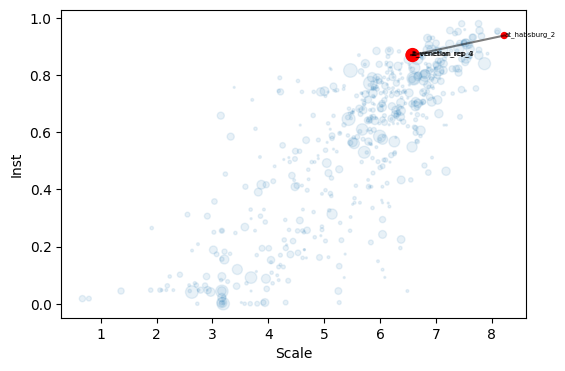

['in_vijayanagara_emp', 'in_madurai_nayaks', 'in_carnatic_sul', 'in_east_india_co', 'gb_british_emp_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


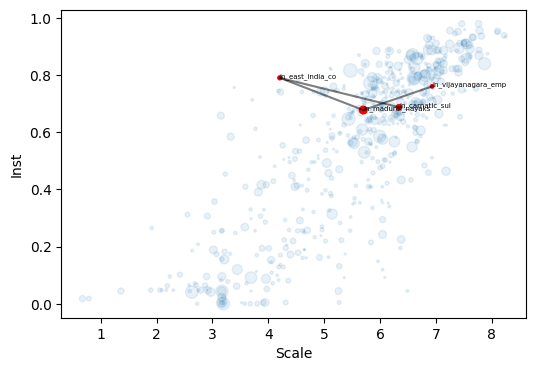

['kz_kazakh_khanate_1', 'kz_kazakh_khanate_2', 'ru_romanov_dyn_2', 'pl_polish_rep_1', 'de_ns_germany']


C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_22884\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


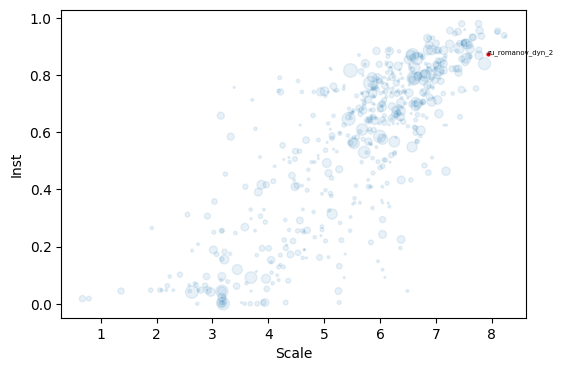

In [91]:
NGAs = dataset_FULL.scv_imputed['NGA'].unique()

for thread in threads:
    if len(thread) < 5:
        continue
    print(thread)

    dataset_plot = dataset_FULL.scv_imputed
    # dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
    polity_group = dataset_FULL.scv_imputed.groupby('PolityName')
    fig, ax = plt.subplots(figsize=(6, 4))
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    # mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    v_max = mean_crisis.max()*0.6
    # add label with polity names on each bubble
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        # c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=0.1,
                        # edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    thread_df = dataset_FULL.scv_imputed.loc[dataset_FULL.scv_imputed.PolityName.isin(thread)]
    thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
    polity_group = thread_df.groupby('PolityName')
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    # mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    if pd.isna(mean_crisis).all() or pd.isna(mean_inst_1).all() or pd.isna(mean_scale_1).all():
        continue

    for i in range(1,len(mean_inst_1)):
        dx = (mean_scale_1[i-1] - mean_scale_1[i]) 
        dy = (mean_inst_1[i-1] - mean_inst_1[i]) 
        plt.plot([mean_scale_1[i-1], mean_scale_1[i]], [mean_inst_1[i-1], mean_inst_1[i]], 'k-', alpha=0.5)
        # plt.arrow(mean_scale_1[i], mean_inst_1[i],dx,dy, head_width=0.04, head_length=0.15, fc='k', ec='k', length_includes_head = True, alpha = 0.5)
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        c='r',
                        # cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=1.0,
                        # edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    # Add a color bar
    # plt.colorbar(scatter, label='Crisis')

    # add label with polity names on each bubble
    for i, txt in enumerate(mean_scale_1.index):
        plt.annotate(txt, (mean_scale_1[i], mean_inst_1[i]), fontsize=5)

    # Show the plot
    plt.ylabel('Inst')
    plt.xlabel('Scale')
    # plt.title(nga)
    plt.show()